In [1]:
import logging

logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jupyter_black

jupyter_black.load()

In [4]:
from glicko2 import glicko2

glicko2.__file__

'/home/cpennington/projects/yomi-skill/.venv/lib/python3.10/site-packages/glicko2/glicko2.cpython-310-x86_64-linux-gnu.so'

In [5]:
import os
import multiprocessing

# Disable CUDA because only one gpu device allows only a single chain
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax

jax.default_backend()
jax.devices()

2023-08-11 07:18:51.857273: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-11 07:18:51 INFO     Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
2023-08-11 07:18:51 INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA
2023-08-11 07:18:51 INFO     Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-08-11 07:18:51 WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [6]:
from yomi_skill.model import YomiModel, weight_by
from yomi_skill.models import *
from yomi_skill.models.mu_glicko import *
from yomi_skill.games import yomi, yomi2
import pandas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tempfile

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, cross_validate

from model_diagnostics.scoring import SquaredError, decompose
import polars as pl

2023-08-11 07:18:58 WARNING  Using NumPy C-API based implementation for BLAS functions.


In [7]:
from sklearn import set_config

set_config(transform_output="pandas")

In [8]:
fit_dir = tempfile.mkdtemp()

# Set up games

In [9]:
y1_tournament_games = yomi.latest_tournament_games()
y1_sirlin_games = yomi.sirlin_db()
y1_games = pandas.concat([y1_tournament_games, y1_sirlin_games]).reset_index(drop=True)

In [10]:
y2_games = yomi2.latest_tournament_games()

,match_date,player_1,character_1,gem_1,player_2,character_2,gem_2,winner,source
0,7/18/2023,vengefulpickle,Grave,Purple,cpat,Argagarg,Red,P2,Self
1,7/1/2023,Bob199,Rook,Purple,jjjdragon31,Jaina,Red,P1,https://forums.sirlingames.com/t/yomi-2-kickof...
2,7/1/2023,Bob199,Rook,Purple,jjjdragon31,Jaina,Red,P1,https://forums.sirlingames.com/t/yomi-2-kickof...
3,7/1/2023,Bob199,Rook,Purple,jjjdragon31,Jaina,Red,P2,https://forums.sirlingames.com/t/yomi-2-kickof...
4,7/1/2023,Feathers,Jaina,Purple,shobbs,Setsuki,White,P1,https://forums.sirlingames.com/t/yomi-2-kickof...
...,...,...,...,...,...,...,...,...,...
122,7/12/2023,cpat,Jaina,White,shobbs,Valerie,White,P1,https://www.youtube.com/watch?v=_6jnAzsLORE&li...
123,7/12/2023,cpat,Jaina,White,MollyWantsHugs,DeGrey,White,P1,https://www.youtube.com/watch?v=L-SwZoeunY0&li...
124,7/12/2023,cpat,Jaina,White,MollyWantsHugs,DeGrey,White,P1,https://www.youtube.com/watch?v=L-SwZoeunY0&li...
125,7/12/2023,cpat,Jaina,White,TawnyOwl,Setsuki,Purple,P1,https://www.youtube.com/watch?v=IBokUth1sEE&li...


In [11]:
y1_games = yomi.augment_dataset(y1_games)
y2_games = yomi2.augment_dataset(y2_games)

Constructing PC category
Constructing PC category


In [12]:
y2_games

,match_date,player_1,character_1,gem_1,player_2,character_2,gem_2,winner,source,win,public,player_character_1,player_character_2
67,2023-06-25,cpat,grave,white,sardek,geiger,white,P1,https://www.youtube.com/watch?v=jf9E2FbmrEs&li...,True,True,cpat-grave,sardek-geiger
66,2023-06-25,cpat,grave,white,sardek,geiger,white,P2,https://www.youtube.com/watch?v=jf9E2FbmrEs&li...,False,True,cpat-grave,sardek-geiger
73,2023-06-25,WittyPossum,rook,red,cpat,setsuki,blue,P1,https://www.youtube.com/watch?v=Dwh0h8Jw_mc&li...,0,True,WittyPossum-rook,cpat-setsuki
72,2023-06-25,WittyPossum,rook,red,cpat,setsuki,blue,P1,https://www.youtube.com/watch?v=Dwh0h8Jw_mc&li...,0,True,WittyPossum-rook,cpat-setsuki
71,2023-06-25,WittyPossum,rook,red,cpat,setsuki,blue,P2,https://www.youtube.com/watch?v=Dwh0h8Jw_mc&li...,1,True,WittyPossum-rook,cpat-setsuki
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,2023-07-12,sardek,midori,black,cpat,jaina,white,P1,https://www.youtube.com/watch?v=anla5DxubjI&li...,0,True,sardek-midori,cpat-jaina
0,2023-07-18,vengefulpickle,grave,purple,cpat,argagarg,red,P2,Self,False,True,vengefulpickle-grave,cpat-argagarg
39,2023-07-26,noshots00,grave,purple,vengefulpickle,jaina,white,P1,self,0,True,noshots00-grave,vengefulpickle-jaina
38,2023-07-26,noshots00,grave,purple,vengefulpickle,jaina,white,P2,self,1,True,noshots00-grave,vengefulpickle-jaina


# Set up models

In [13]:
min_games = 0
warmup = 500
samples = 1000

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    y2_games,
    y2_games.win.astype("int"),
)

In [15]:
from yomi_skill.models.yomi2 import *

In [16]:
MODELS = {
    model.model_name: model
    for model_type in YomiModel.__subclasses__()
    for model in model_type.__subclasses__()
}

In [17]:
MODELS

{'mu_pc_glicko': yomi_skill.models.mu_pc_glicko.MUPCGlicko,
 'pc_elo': yomi_skill.models.pc_elo.PCElo,
 'mu_pc_elo_c': yomi_skill.models.mu_pc_elo_c.MUPCEloC,
 'char_skill_skelo_skill_deficit': yomi_skill.models.char_skill_skelo_skill_deficit.CharSkillSkeloSkillDeficit,
 'mu': yomi_skill.models.mu_only.MUOnly,
 'glicko': yomi_skill.models.glicko.Glicko,
 'elo': yomi_skill.models.elo.Elo,
 'full_glicko_no_scale': yomi_skill.models.full_glicko_no_scale.FullGlickoNoScale,
 'mu_pc_elo_vol': yomi_skill.models.mu_pc_elo_vol.MUPCEloVol,
 'char_skill_glicko_skill_deficit': yomi_skill.models.char_skill_glicko_skill_deficit.CharSkillGlickoSkillDeficit,
 'mu_pc_elo': yomi_skill.models.mu_pc_elo.MUPCElo,
 'full_glicko': yomi_skill.models.full_glicko.FullGlicko,
 'custom_glicko': yomi_skill.models.custom_glicko.CustomGlicko,
 'full': yomi_skill.models.full.Full,
 'mu_elo': yomi_skill.models.mu_elo.MUElo,
 'mu_glicko': yomi_skill.models.mu_glicko.MUGlicko,
 'pc_glicko': yomi_skill.models.pc_glicko_o

In [18]:
model_names = [
    "y2_full_glicko_no_scale",
]
models = {
    model_name: MODELS[model_name](min_games=min_games, warmup=warmup, samples=samples)
    for model_name in model_names
}

In [19]:
parameters = {}
parameters["y2_full_glicko_no_scale"] = [
    dict(
        transform__glicko__initial_time=pandas.concat(
            [y1_games.match_date, y2_games.match_date]
        ).min(),
        transform__pc_glicko__initial_time=pandas.concat(
            [y1_games.match_date, y2_games.match_date]
        ).min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
        transform__glicko__initial_value=(1500.0, 50, 0.059),
        transform__pc_glicko__initial_value=(1500.0, 40, 0.027),
        transform__glicko__rating_period="1D",
        transform__pc_glicko__rating_period="8D",
        verbose=True,
        prefit_games=y1_games,
    ),
]

In [20]:
pipelines = {
    f"{model_name}-{idx}": MODELS[model_name].pipeline(**params)
    for model_name in model_names
    for idx, params in enumerate(parameters[model_name])
}

2023-08-11 07:19:23 INFO     Starting Glicko2Estimator.fit
2023-08-11 07:20:22 INFO     Ending Glicko2Estimator.fit
2023-08-11 07:20:22 INFO     Starting Glicko2Estimator.fit
2023-08-11 07:20:55 INFO     Ending Glicko2Estimator.fit


# Fit Models

In [21]:
for model_name in pipelines:
    if not hasattr(pipelines[model_name]["model"], "inf_data_"):
        pipelines[model_name].fit(
            X_train,
            y_train,
            # sample_weight=X_train[f'{models[model_name].weight_key}_weight']
        )

2023-08-11 07:20:56 INFO     Starting Glicko2Estimator.fit
2023-08-11 07:20:56 INFO     Ending Glicko2Estimator.fit
2023-08-11 07:20:56 INFO     Starting Glicko2Estimator.transform
2023-08-11 07:20:56 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-11 07:20:56 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-11 07:20:56 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-11 07:20:56 INFO     Ending Glicko2Estimator.transform
2023-08-11 07:20:56 INFO     Starting Glicko2Estimator.fit
2023-08-11 07:20:57 INFO     Ending Glicko2Estimator.fit
2023-08-11 07:20:57 INFO     Starting Glicko2Estimator.transform
2023-08-11 07:20:57 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-11 07:20:57 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-11 07:20:57 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-11 07:20:57 INFO     Ending Glicko2Estimator.transform
2023-08-11 07:20:57 INFO     Startin

[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.4s
Compiling...
Compilation time =  0:00:04.373898
Sampling...
Sampling time =  0:00:10.206109
Transforming variables...
Transformation time =  0:00:00.873296
[Pipeline] ............. (step 2 of 2) Processing model, total=  19.5s


In [22]:
pipelines["y2_full_glicko_no_scale-0"]["transform"].named_transformers_[
    "glicko"
].rating_model.ratings["Bob199"]

[{'rating': (1500.0, 50, 0.059),
  'valid_from': Timestamp('2013-06-15 00:00:00'),
  'valid_to': None,
  'trailing_empty_periods': 0},
 {'rating': (1507.252604712505, 50.51080543478728, 0.05900000035762787),
  'valid_from': Timestamp('2013-06-16 00:00:00', freq='D'),
  'valid_to': None,
  'trailing_empty_periods': 0},
 {'rating': (1499.8203546485543, 39.939656332656746, 0.05891477316617966),
  'valid_from': Timestamp('2013-06-17 00:00:00', freq='D'),
  'valid_to': None,
  'trailing_empty_periods': 0},
 {'rating': (1550.0323861255229, 35.04082981311977, 0.0594564825296402),
  'valid_from': Timestamp('2013-06-18 00:00:00', freq='D'),
  'valid_to': None,
  'trailing_empty_periods': 0},
 {'rating': (1524.526601369104, 32.05685575365126, 0.05949782952666283),
  'valid_from': Timestamp('2013-06-19 00:00:00', freq='D'),
  'valid_to': None,
  'trailing_empty_periods': 0},
 {'rating': (1510.1683660068572, 30.167151512855295, 0.05949725955724716),
  'valid_from': Timestamp('2013-06-20 00:00:00',

# Render matchup data

In [32]:
from yomi_skill.render import *

render_games = y2_games
render = YomiRender(pipelines["y2_full_glicko_no_scale-0"], "src-js/data/yomi2")
display(pipelines["y2_full_glicko_no_scale-0"]["model"].data_)
render.render_aggregate_skill()
render.render_players()
render.render_characters()
render.render_matchup_data()
render.render_player_details()
render.render_scales()
render.render_gem_effects()

,glicko__prob,glicko__r1,glicko__rd1,glicko__v1,glicko__r2,glicko__rd2,glicko__v2,pc_glicko__prob,pc_glicko__r1,pc_glicko__rd1,...,gem__with_gem_2,gem__against_gem_1,gem__against_gem_2,gem__gem_1,gem__gem_2,gem__character_1,gem__character_2,render__match_date,render__win,render__public
26,0.423605,1514.712292,50.340129,0.058996,1569.298609,39.043417,0.058306,0.504531,1500.000000,39.999999,...,setsuki-red,blue-setsuki,red-setsuki,blue,red,setsuki,setsuki,2023-07-01,0,True
11,0.596540,1569.298609,39.043417,0.058306,1500.000000,49.999998,0.059000,0.559645,1542.230477,34.891209,...,setsuki-white,purple-setsuki,white-rook,purple,white,rook,setsuki,2023-07-01,True,True
46,0.586264,1561.780687,39.795109,0.058282,1500.000000,49.999998,0.059000,0.491336,1493.897326,33.458827,...,argagarg-red,black-argagarg,red-setsuki,black,red,setsuki,argagarg,2023-07-09,True,True
119,0.147081,1467.813010,47.332977,0.059081,1779.581268,44.537209,0.058635,0.425012,1472.649343,37.634884,...,geiger-black,black-geiger,black-setsuki,black,black,setsuki,geiger,2023-07-09,1,True
67,0.846732,1803.400315,43.390543,0.058650,1500.000000,49.999998,0.059000,0.515964,1511.270466,39.180781,...,geiger-white,white-geiger,white-grave,white,white,grave,geiger,2023-06-25,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.237770,1566.146718,40.755841,0.058968,1772.144767,43.923484,0.058629,0.456455,1482.516993,39.603297,...,argagarg-red,purple-argagarg,red-grave,purple,red,grave,argagarg,2023-07-18,False,True
79,0.177225,1520.230611,40.547715,0.058958,1791.642121,43.507760,0.058648,0.499248,1500.000000,39.999999,...,argagarg-white,red-argagarg,white-rook,red,white,rook,argagarg,2023-06-28,0,True
9,0.479356,1500.000000,49.999998,0.059000,1514.712292,50.340129,0.058996,0.500000,1500.000000,39.999999,...,jaina-purple,red-jaina,purple-grave,red,purple,grave,jaina,2023-07-01,1,True
87,0.220108,1569.298609,39.043417,0.058306,1792.800880,43.433897,0.058642,0.464412,1496.808143,33.600056,...,geiger-white,white-geiger,white-setsuki,white,white,setsuki,geiger,2023-06-30,0,True


Computing player skill
Computing matchup dict


/home/cpennington/projects/yomi-skill/src/yomi_skill/render.py:537: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  character_std = character_ratings.std()


Computing per-player data for 19 players
Computing matchup dict


In [45]:
{
    character: [
        {
            "player": player,
            "r": round(row.pc_glicko_r, 2),
            "rd": round(row.pc_glicko_rd, 2),
            "v": round(row.pc_glicko_v, 3),
        }
        for (player, character), row in pc_ratings.sort_values(
            "pc_glicko_r", ascending=False
        )
        .head(20)
        .iterrows()
    ]
    for character, pc_ratings in intermediate["player_character_ratings"]
    .loc[intermediate["public_players"], :]
    .groupby("character")
}

NameError: name 'intermediate' is not defined

In [79]:

    [
        {
            "player": player,
            "r": round(row.glicko_r, 2),
            "rd": round(row.glicko_rd, 2),
            "v": round(row.glicko_v, 3),
        }
        for player, row in intermediate["player_ratings"]
    .loc[intermediate["public_players"], :].sort_values(
            "glicko_r", ascending=False
        )
        .head(20)
        .iterrows()
    ]

[{'player': 'EricF', 'r': 1641.86, 'rd': 56.95, 'v': 0.059},
 {'player': 'ClanNatioy', 'r': 1616.42, 'rd': 58.88, 'v': 0.059},
 {'player': 'enomus', 'r': 1615.21, 'rd': 56.9, 'v': 0.059},
 {'player': 'ntillerman', 'r': 1615.13, 'rd': 56.37, 'v': 0.059},
 {'player': 'cpat', 'r': 1612.84, 'rd': 55.68, 'v': 0.059},
 {'player': 'Ryker', 'r': 1612.26, 'rd': 58.91, 'v': 0.059},
 {'player': 'Caralad', 'r': 1612.18, 'rd': 58.58, 'v': 0.059},
 {'player': 'Jengajam', 'r': 1606.48, 'rd': 58.35, 'v': 0.059},
 {'player': 'tipzntrix', 'r': 1604.95, 'rd': 56.17, 'v': 0.059},
 {'player': 'Bob199', 'r': 1597.95, 'rd': 57.24, 'v': 0.059},
 {'player': 'drnd', 'r': 1597.09, 'rd': 54.42, 'v': 0.059},
 {'player': 'Raziek', 'r': 1591.34, 'rd': 56.73, 'v': 0.059},
 {'player': 'Fivec', 'r': 1582.94, 'rd': 58.3, 'v': 0.059},
 {'player': 'Zqxx', 'r': 1574.6, 'rd': 56.02, 'v': 0.059},
 {'player': 'mi-go hunter', 'r': 1570.92, 'rd': 57.83, 'v': 0.059},
 {'player': 'Kirandio', 'r': 1568.71, 'rd': 54.5, 'v': 0.059},

In [68]:
intermediate["player_character_ratings"].loc[intermediate["public_players"]]

render__match_date  pc_elo  pc_glicko_r  \
player         character                                            
flagrantangles grave              2017-02-04     NaN  1508.920858   
               midori                    NaT     NaN  1500.000000   
               rook                      NaT     NaN  1500.000000   
               valerie            2019-02-25     NaN  1495.370874   
               lum                       NaT     NaN  1500.000000   
...                                      ...     ...          ...   
Soulpech       onimaru                   NaT     NaN  1500.000000   
               troq                      NaT     NaN  1500.000000   
               persephone                NaT     NaN  1500.000000   
               gwen                      NaT     NaN  1500.000000   
               zane                      NaT     NaN  1500.000000   

                           pc_glicko_rd  pc_glicko_v  
player         character                              
flagrantangles grave          40.020723        0.027  
               midori         40.000000        0.027  
               rook           40.000000        0.027  
               valerie        40.010395        0.027  
               lum            40.000000        0.027  
...                                 ...          ...  
Soulpech       onimaru        40.000000        0.027  
               troq           40.000000        0.027  
               persephone     40.000000        0.027  
               gwen           40.000000        0.027  
               zane           40.000000        0.027  

[4900 rows x 5 columns]

# Validate models

In [37]:
pred_test = {
    model_name: pipelines[model_name].predict_proba(X_test)[:, 1]
    for model_name in pipelines
    if hasattr(pipelines[model_name]["model"], "inf_data_")
}

2023-08-10 07:11:42 INFO     Starting Glicko2Estimator.transform
2023-08-10 07:11:42 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-10 07:11:42 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-10 07:11:42 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-10 07:11:42 INFO     Ending Glicko2Estimator.transform
2023-08-10 07:11:42 INFO     Starting Glicko2Estimator.transform
2023-08-10 07:11:42 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-10 07:11:42 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-10 07:11:42 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-10 07:11:42 INFO     Ending Glicko2Estimator.transform
2023-08-10 07:11:42 INFO     Starting _transform_min_games
2023-08-10 07:11:42 INFO     Ending _transform_min_games
2023-08-10 07:11:42 INFO     Starting _transform_matchup
2023-08-10 07:11:42 INFO     Ending _transform_matchup
2023-08-10 07:11:42 INFO     Starting _t

In [38]:
df_pred_test = pandas.DataFrame(pred_test)

2023-08-10 07:11:48 INFO     Starting Glicko2Estimator.transform
2023-08-10 07:11:48 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-10 07:11:48 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-10 07:11:48 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-10 07:11:48 INFO     Ending Glicko2Estimator.transform
2023-08-10 07:11:48 INFO     Starting Glicko2Estimator.transform
2023-08-10 07:11:48 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-10 07:11:48 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-10 07:11:48 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-10 07:11:48 INFO     Ending Glicko2Estimator.transform
2023-08-10 07:11:48 INFO     Starting _transform_min_games
2023-08-10 07:11:48 INFO     Ending _transform_min_games
2023-08-10 07:11:48 INFO     Starting _transform_matchup
2023-08-10 07:11:48 INFO     Ending _transform_matchup
2023-08-10 07:11:48 INFO     Starting _t

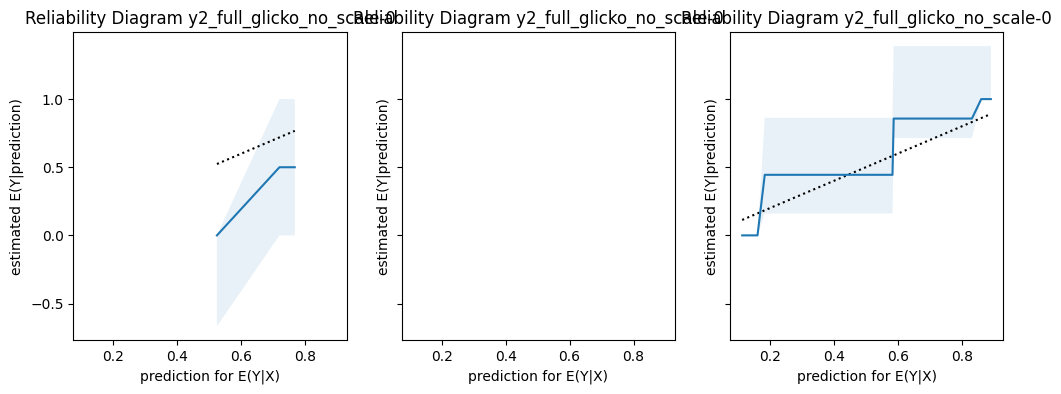

In [39]:
import matplotlib.pyplot as plt
from model_diagnostics.calibration import (
    compute_bias,
    plot_bias,
    plot_reliability_diagram,
)

fig, axes = plt.subplots(
    ncols=3,
    nrows=len(pred_test),
    figsize=(12, 4 * len(pred_test)),
    sharex=True,
    sharey=True,
)
mirror_matches = (X_test.character_1 == X_test.character_2).to_numpy()

for i, model_name in enumerate(pred_test):
    elo_test = pipelines[model_name]["transform"].transform(X_test)
    near_skill = (
        (
            elo_test["glicko__prob" if "glicko" in model_name else "elo__prob"] - 0.5
        ).abs()
        < 0.02
    ).to_numpy()
    plot_reliability_diagram(
        y_obs=y_test[mirror_matches],
        y_pred=df_pred_test[model_name][mirror_matches],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][0] if len(pred_test) > 1 else axes[0],
    )
    plot_reliability_diagram(
        y_obs=y_test[near_skill],
        y_pred=df_pred_test[model_name][near_skill],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][1] if len(pred_test) > 1 else axes[1],
    )
    plot_reliability_diagram(
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][2] if len(pred_test) > 1 else axes[2],
    )

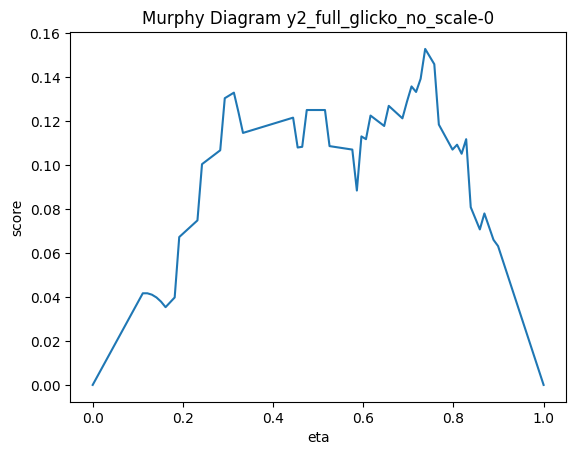

In [40]:
from model_diagnostics.scoring import SquaredError, plot_murphy_diagram

ax = plot_murphy_diagram(
    y_obs=y_test,
    y_pred=df_pred_test,
)

In [41]:
df_list = []
for model_name in df_pred_test:
    df = decompose(
        scoring_function=SquaredError(),
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
    )
    df = df.with_columns(pl.lit(model_name).alias("model"))
    df_list.append(df)
pl.concat(df_list)[:, [-1, 0, 1, 2, 3]]

model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""y2_full_glicko…",0.053253,0.111359,0.234375,0.176269


In [42]:
import arviz

for model in df_pred_test:
    print(model)
    display(pipelines[model]["model"].data_)
    display(arviz.summary(pipelines[model]["model"].inf_data_))

y2_full_glicko_no_scale-0


,glicko__prob,glicko__r1,glicko__rd1,glicko__v1,glicko__r2,glicko__rd2,glicko__v2,pc_glicko__prob,pc_glicko__r1,pc_glicko__rd1,...,matchup__non_mirror,gem__with_gem_1,gem__with_gem_2,gem__against_gem_1,gem__against_gem_2,gem__gem_1,gem__gem_2,render__match_date,render__win,render__public
42,0.847221,1787.012736,44.778580,0.058632,1483.001926,48.340909,0.059007,0.545557,1515.947924,38.025635,...,1,rook-white,setsuki-black,white-setsuki,black-rook,white,black,2023-07-09,True,True
55,0.772073,1787.012736,44.778580,0.058632,1571.298233,39.470636,0.058278,0.459856,1515.947924,38.025635,...,0,rook-white,rook-white,white-rook,white-rook,white,white,2023-07-09,0,True
79,0.169849,1520.230611,40.547715,0.058958,1800.755659,43.679591,0.058647,0.499248,1500.000000,39.999999,...,1,rook-red,argagarg-white,red-argagarg,white-rook,red,white,2023-06-28,0,True
35,0.560293,1560.487558,41.633572,0.059075,1517.485444,50.625920,0.059001,0.500000,1500.000000,39.999999,...,1,rook-purple,jaina-black,purple-jaina,black-rook,purple,black,2023-07-01,False,True
44,0.599237,1571.298233,39.470636,0.058278,1500.000000,49.999998,0.059000,0.486919,1490.784917,33.307197,...,1,setsuki-white,argagarg-red,white-argagarg,red-setsuki,white,red,2023-07-09,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.783223,1801.409166,44.728781,0.058639,1574.167480,40.926688,0.059070,0.518033,1515.947924,38.025635,...,1,rook-white,geiger-purple,white-geiger,purple-rook,white,purple,2023-07-05,True,True
15,0.415567,1500.000000,49.999998,0.059000,1560.487558,41.633572,0.059075,0.500000,1500.000000,39.999999,...,1,grave-red,rook-purple,red-rook,purple-grave,red,purple,2023-07-01,0,True
32,0.394200,1500.000000,49.999998,0.059000,1576.138407,38.883739,0.058304,0.440355,1500.000000,39.999999,...,1,grave-black,rook-purple,black-rook,purple-grave,black,purple,2023-07-01,1,True
24,0.418019,1517.485444,50.625920,0.059001,1576.138407,38.883739,0.058304,0.504531,1500.000000,39.999999,...,0,setsuki-green,setsuki-white,green-setsuki,white-setsuki,green,white,2023-07-01,1,True


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[grave-grave],-0.003,0.495,-0.891,0.999,0.005,0.009,11226.0,2652.0,1.0
mu[grave-midori],-0.000,0.505,-0.942,0.974,0.005,0.010,12285.0,2241.0,1.0
mu[grave-rook],-0.195,0.451,-0.990,0.675,0.005,0.007,9192.0,2918.0,1.0
mu[grave-valerie],0.001,0.488,-0.887,0.918,0.004,0.009,12679.0,2675.0,1.0
mu[grave-lum],-0.001,0.512,-0.950,0.975,0.005,0.011,9446.0,2511.0,1.0
...,...,...,...,...,...,...,...,...,...
against_gem[white-zane],0.007,0.497,-0.886,0.965,0.005,0.010,10308.0,2547.0,1.0
against_gem[black-zane],-0.003,0.515,-0.980,0.929,0.005,0.010,9202.0,2690.0,1.0
against_gem[purple-zane],-0.007,0.490,-0.915,0.905,0.005,0.009,10943.0,2453.0,1.0
against_gem[green-zane],0.003,0.496,-0.917,0.930,0.005,0.009,8926.0,2343.0,1.0


# Parameter Search

In [35]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
from scipy.stats import loguniform, uniform
from sklearn.model_selection import GridSearchCV

initial_values = [(1500.0, rd, v) for rd in [100, 350, 500] for v in [0.03, 0.06, 0.09]]
pc_init_values = [
    (1500.0, rd, v) for rd in [500, 750, 1000] for v in [0.05, 0.06, 0.07]
]
search = HalvingGridSearchCV(
    pipelines["full_glicko4"],
    {
        "transform__glicko__initial_value": initial_values,
        "transform__pc_glicko__initial_value": initial_values,
    },
    scoring="neg_brier_score",
    verbose=2,
    min_resources="exhaust",
)
search.fit(X_train, y_train)

KeyError: 'full_glicko4'

In [44]:
search.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4]),
 'n_resources': array([ 1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,
         1113,  1113,  1113,  1113,  1113,  1113,  1113,  1113,  11

In [18]:
from hyperactive import Hyperactive
from hyperactive.optimizers import (
    BayesianOptimizer,
    HillClimbingOptimizer,
    PowellsMethod,
)
import logging

logger = logging.getLogger("hyper")
logging.getLogger().setLevel(logging.INFO)
logging.basicConfig()

pipeline = models["full_glicko_no_scale"].pipeline(
    **parameters["full_glicko_no_scale"][0]
)


def evaluate(params):
    logger.info("Starting evaluation with params %r", {**params})
    pipeline.set_params(
        transform__glicko__initial_value=(
            1500.0,
            params["glicko_init_rd"],
            params["glicko_init_v"],
        ),
        transform__pc_glicko__initial_value=(
            1500.0,
            params["pc_glicko_init_rd"],
            params["pc_glicko_init_v"],
        ),
        transform__glicko__rating_period=f"{params['glicko_rating_period']}D",
        transform__pc_glicko__rating_period=f"{params['pc_glicko_rating_period']}D",
    )
    pipeline.fit(
        X_train,
        y_train,
    )
    y_pred = pipeline.predict_proba(X_test)[:, 1]
    df = decompose(
        scoring_function=SquaredError(),
        y_obs=y_test,
        y_pred=y_pred,
    )
    results = {key: value[0] for key, value in df.to_dict().items()}
    logger.info("Evaluation results %r", results)
    return (1 - results["score"]), results

In [20]:
search_space = dict(
    glicko_init_rd=list(numpy.arange(10, 700, 10)),
    pc_glicko_init_rd=list(numpy.arange(10, 700, 10)),
    glicko_init_v=list(numpy.arange(0.001, 0.1, 0.001)),
    pc_glicko_init_v=list(numpy.arange(0.001, 0.1, 0.001)),
    glicko_rating_period=list(range(1, 30, 1)),
    pc_glicko_rating_period=list(range(1, 30, 1)),
)

ws = [
    # {
    #     "glicko_init_rd": 30,
    #     "glicko_init_v": 0.09,
    #     "pc_glicko_init_rd": 50,
    #     "pc_glicko_init_v": 0.007,
    #     "glicko_rating_period": 3,
    #     "pc_glicko_rating_period": 3,
    # },
    # {
    #     "glicko_init_rd": 40,
    #     "glicko_init_v": 0.049,
    #     "pc_glicko_init_rd": 110,
    #     "pc_glicko_init_v": 0.081,
    #     "glicko_rating_period": 7,
    #     "pc_glicko_rating_period": 14,
    # },
    # {
    #     "glicko_init_rd": 30,
    #     "glicko_init_v": 0.09,
    #     "pc_glicko_init_rd": 50,
    #     "pc_glicko_init_v": 0.007,
    #     "glicko_rating_period": 2,
    #     "pc_glicko_rating_period": 2,
    # },
    {
        "glicko_init_rd": 60,
        "pc_glicko_init_rd": 40,
        "glicko_init_v": 0.059,
        "pc_glicko_init_v": 0.027,
        "glicko_rating_period": 1,
        "pc_glicko_rating_period": 6,
    }
]

hyper = Hyperactive()
bayes = BayesianOptimizer(
    # warm_start_smbo=search_data
)
hill = HillClimbingOptimizer(epsilon=0.1)
powell = PowellsMethod()
hyper.add_search(
    evaluate,
    search_space,
    n_iter=70,
    optimizer=powell,
    initialize={
        "warm_start": ws,
        # "random": 5
    },
)
hyper.run()

[0] evaluate (Powell's Method):   0%|                                                                                                                                                                                                                                                                                | 0/70 [00:00<?, ?it/s]2023-08-06 20:42:52 INFO     Starting evaluation with params {'glicko_init_rd': 60, 'pc_glicko_init_rd': 40, 'glicko_init_v': 0.059000000000000004, 'pc_glicko_init_v': 0.027000000000000003, 'glicko_rating_period': 1, 'pc_glicko_rating_period': 6}
2023-08-06 20:42:52 INFO     Starting Glicko2Estimator.fit
2023-08-06 20:43:14 INFO     Ending Glicko2Estimator.fit
2023-08-06 20:43:14 INFO     Starting Glicko2Estimator.transform
2023-08-06 20:43:15 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 20:43:19 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 20:43:24 INFO     Restacking columns in Glicko2Estimator.transform
20

Compiling...
Compilation time =  0:00:03.388062
Sampling...
Sampling time =  0:00:05.638703
Transforming variables...


2023-08-06 20:47:15 INFO     Starting Glicko2Estimator.transform
2023-08-06 20:47:15 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:38.136097


2023-08-06 20:47:16 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 20:47:18 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 20:47:18 INFO     Ending Glicko2Estimator.transform
2023-08-06 20:47:18 INFO     Starting Glicko2Estimator.transform
2023-08-06 20:47:18 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 20:47:18 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 20:47:19 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 20:47:19 INFO     Ending Glicko2Estimator.transform
2023-08-06 20:47:19 INFO     Starting _transform_min_games
2023-08-06 20:47:19 INFO     Ending _transform_min_games
2023-08-06 20:47:19 INFO     Starting _transform_matchup
2023-08-06 20:47:32 INFO     Ending _transform_matchup
2023-08-06 20:47:32 INFO     Evaluation results {'miscalibration': 0.0005017120804666486, 'discrimination': 0.010786254498967723, 'uncertainty': 0.24998174687517713, 'score': 0.23969720445

Compiling...
Compilation time =  0:00:03.083925
Sampling...
Sampling time =  0:00:05.588831
Transforming variables...


2023-08-06 20:52:04 INFO     Starting Glicko2Estimator.transform


Transformation time =  0:02:45.639587


2023-08-06 20:52:04 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 20:52:06 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 20:52:08 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 20:52:08 INFO     Ending Glicko2Estimator.transform
2023-08-06 20:52:08 INFO     Starting Glicko2Estimator.transform
2023-08-06 20:52:08 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 20:52:09 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 20:52:09 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 20:52:09 INFO     Ending Glicko2Estimator.transform
2023-08-06 20:52:09 INFO     Starting _transform_min_games
2023-08-06 20:52:09 INFO     Ending _transform_min_games
2023-08-06 20:52:09 INFO     Starting _transform_matchup
2023-08-06 20:52:22 INFO     Ending _transform_matchup
2023-08-06 20:52:22 INFO     Evaluation results {'miscalibration': 0.00043358778056878933, 'discriminatio

Compiling...
Compilation time =  0:00:03.104467
Sampling...
Sampling time =  0:00:06.152938
Transforming variables...


2023-08-06 20:56:46 INFO     Starting Glicko2Estimator.transform
2023-08-06 20:56:46 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:37.124078


2023-08-06 20:56:47 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 20:56:49 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 20:56:49 INFO     Ending Glicko2Estimator.transform
2023-08-06 20:56:49 INFO     Starting Glicko2Estimator.transform
2023-08-06 20:56:49 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 20:56:49 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 20:56:50 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 20:56:50 INFO     Ending Glicko2Estimator.transform
2023-08-06 20:56:50 INFO     Starting _transform_min_games
2023-08-06 20:56:50 INFO     Ending _transform_min_games
2023-08-06 20:56:50 INFO     Starting _transform_matchup
2023-08-06 20:57:03 INFO     Ending _transform_matchup
2023-08-06 20:57:03 INFO     Evaluation results {'miscalibration': 0.00042163102738201896, 'discrimination': 0.009578267163172532, 'uncertainty': 0.24998174687517713, 'score': 0.2408251107

Compiling...
Compilation time =  0:00:03.603263
Sampling...
Sampling time =  0:00:05.608752
Transforming variables...


2023-08-06 21:01:27 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:01:27 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:35.875639


2023-08-06 21:01:28 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:01:30 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:01:30 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:01:30 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:01:30 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:01:31 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:01:31 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:01:31 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:01:31 INFO     Starting _transform_min_games
2023-08-06 21:01:31 INFO     Ending _transform_min_games
2023-08-06 21:01:31 INFO     Starting _transform_matchup
2023-08-06 21:01:45 INFO     Ending _transform_matchup
2023-08-06 21:01:45 INFO     Evaluation results {'miscalibration': 0.0004433016331086559, 'discrimination': 0.008961806151970897, 'uncertainty': 0.24998174687517713, 'score': 0.24146324235

Compiling...
Compilation time =  0:00:03.063074
Sampling...
Sampling time =  0:00:05.388793
Transforming variables...


2023-08-06 21:06:03 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:06:03 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:33.577432


2023-08-06 21:06:04 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:06:06 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:06:06 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:06:06 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:06:06 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:06:06 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:06:07 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:06:07 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:06:07 INFO     Starting _transform_min_games
2023-08-06 21:06:07 INFO     Ending _transform_min_games
2023-08-06 21:06:07 INFO     Starting _transform_matchup
2023-08-06 21:06:20 INFO     Ending _transform_matchup
2023-08-06 21:06:20 INFO     Evaluation results {'miscalibration': 0.00044944067700566914, 'discrimination': 0.008988511081935768, 'uncertainty': 0.24998174687517713, 'score': 0.2414426764

Compiling...
Compilation time =  0:00:03.476323
Sampling...
Sampling time =  0:00:05.301944
Transforming variables...


2023-08-06 21:11:52 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:11:52 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:03:51.005297


2023-08-06 21:11:54 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:11:55 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:11:55 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:11:55 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:11:55 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:11:56 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:11:56 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:11:56 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:11:56 INFO     Starting _transform_min_games
2023-08-06 21:11:56 INFO     Ending _transform_min_games
2023-08-06 21:11:56 INFO     Starting _transform_matchup
2023-08-06 21:12:09 INFO     Ending _transform_matchup
2023-08-06 21:12:09 INFO     Evaluation results {'miscalibration': 0.0004190665117374537, 'discrimination': 0.009694848733378503, 'uncertainty': 0.24998174687517713, 'score': 0.24070596465

Compiling...
Compilation time =  0:00:03.121172
Sampling...
Sampling time =  0:00:05.319954
Transforming variables...


2023-08-06 21:16:33 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:16:33 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:44.768114


2023-08-06 21:16:35 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:16:36 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:16:36 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:16:36 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:16:36 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:16:37 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:16:37 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:16:37 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:16:37 INFO     Starting _transform_min_games
2023-08-06 21:16:37 INFO     Ending _transform_min_games
2023-08-06 21:16:37 INFO     Starting _transform_matchup
2023-08-06 21:16:50 INFO     Ending _transform_matchup
2023-08-06 21:16:50 INFO     Evaluation results {'miscalibration': 0.00043610222481210714, 'discrimination': 0.009630919736534571, 'uncertainty': 0.24998174687517713, 'score': 0.2407869293

Compiling...
Compilation time =  0:00:03.003132
Sampling...
Sampling time =  0:00:05.965334
Transforming variables...


2023-08-06 21:21:05 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:21:05 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:34.050735


2023-08-06 21:21:07 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:21:08 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:21:08 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:21:08 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:21:08 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:21:09 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:21:09 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:21:09 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:21:09 INFO     Starting _transform_min_games
2023-08-06 21:21:09 INFO     Ending _transform_min_games
2023-08-06 21:21:09 INFO     Starting _transform_matchup
2023-08-06 21:21:22 INFO     Ending _transform_matchup
2023-08-06 21:21:22 INFO     Evaluation results {'miscalibration': 0.000431514750099643, 'discrimination': 0.009752129904656848, 'uncertainty': 0.24998174687517713, 'score': 0.240661131720

Compiling...
Compilation time =  0:00:03.469190
Sampling...
Sampling time =  0:00:05.472165
Transforming variables...


2023-08-06 21:25:34 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:25:34 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:31.889978


2023-08-06 21:25:36 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:25:38 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:25:38 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:25:38 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:25:38 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:25:38 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:25:38 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:25:38 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:25:38 INFO     Starting _transform_min_games
2023-08-06 21:25:38 INFO     Ending _transform_min_games
2023-08-06 21:25:38 INFO     Starting _transform_matchup
2023-08-06 21:25:51 INFO     Ending _transform_matchup
2023-08-06 21:25:51 INFO     Evaluation results {'miscalibration': 0.00043445209619299985, 'discrimination': 0.009666348642573597, 'uncertainty': 0.24998174687517713, 'score': 0.2407498503

Compiling...
Compilation time =  0:00:03.530952
Sampling...
Sampling time =  0:00:05.539685
Transforming variables...


2023-08-06 21:30:11 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:30:11 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:36.543319


2023-08-06 21:30:13 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:30:15 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:30:15 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:30:15 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:30:15 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:30:15 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:30:16 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:30:16 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:30:16 INFO     Starting _transform_min_games
2023-08-06 21:30:16 INFO     Ending _transform_min_games
2023-08-06 21:30:16 INFO     Starting _transform_matchup
2023-08-06 21:30:29 INFO     Ending _transform_matchup
2023-08-06 21:30:29 INFO     Evaluation results {'miscalibration': 0.00043533882463547835, 'discrimination': 0.009796565356333026, 'uncertainty': 0.24998174687517713, 'score': 0.2406205203

Compiling...
Compilation time =  0:00:03.161821
Sampling...
Sampling time =  0:00:05.549585
Transforming variables...


2023-08-06 21:34:53 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:34:53 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:40.309386


2023-08-06 21:34:55 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:34:56 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:34:56 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:34:56 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:34:56 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:34:57 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:34:57 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:34:57 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:34:57 INFO     Starting _transform_min_games
2023-08-06 21:34:57 INFO     Ending _transform_min_games
2023-08-06 21:34:57 INFO     Starting _transform_matchup
2023-08-06 21:35:10 INFO     Ending _transform_matchup
2023-08-06 21:35:10 INFO     Evaluation results {'miscalibration': 0.0008267931904799852, 'discrimination': 0.010680707753226826, 'uncertainty': 0.24998174687517713, 'score': 0.24012783231

Compiling...
Compilation time =  0:00:03.577354
Sampling...
Sampling time =  0:00:05.366580
Transforming variables...


2023-08-06 21:40:15 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:40:15 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:03:20.190167


2023-08-06 21:40:17 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:40:18 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:40:18 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:40:18 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:40:18 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:40:19 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:40:19 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:40:19 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:40:19 INFO     Starting _transform_min_games
2023-08-06 21:40:19 INFO     Ending _transform_min_games
2023-08-06 21:40:19 INFO     Starting _transform_matchup
2023-08-06 21:40:32 INFO     Ending _transform_matchup
2023-08-06 21:40:32 INFO     Evaluation results {'miscalibration': 0.0008105988730227609, 'discrimination': 0.010700490785067712, 'uncertainty': 0.24998174687517713, 'score': 0.24009185496

Compiling...
Compilation time =  0:00:03.114312
Sampling...
Sampling time =  0:00:05.453574
Transforming variables...


2023-08-06 21:44:51 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:44:51 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:36.476720


2023-08-06 21:44:52 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:44:54 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:44:54 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:44:54 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:44:54 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:44:54 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:44:55 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:44:55 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:44:55 INFO     Starting _transform_min_games
2023-08-06 21:44:55 INFO     Ending _transform_min_games
2023-08-06 21:44:55 INFO     Starting _transform_matchup
2023-08-06 21:45:07 INFO     Ending _transform_matchup
2023-08-06 21:45:07 INFO     Evaluation results {'miscalibration': 0.0008187040048584504, 'discrimination': 0.01070136987569778, 'uncertainty': 0.24998174687517713, 'score': 0.240099081004

Compiling...
Compilation time =  0:00:03.676425
Sampling...
Sampling time =  0:00:05.351255
Transforming variables...


2023-08-06 21:49:23 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:49:23 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:33.856718


2023-08-06 21:49:25 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:49:26 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:49:26 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:49:26 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:49:26 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:49:27 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:49:27 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:49:27 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:49:27 INFO     Starting _transform_min_games
2023-08-06 21:49:27 INFO     Ending _transform_min_games
2023-08-06 21:49:27 INFO     Starting _transform_matchup
2023-08-06 21:49:40 INFO     Ending _transform_matchup
2023-08-06 21:49:40 INFO     Evaluation results {'miscalibration': 0.0008263612113199315, 'discrimination': 0.010703547197105423, 'uncertainty': 0.24998174687517713, 'score': 0.24010456088

Compiling...
Compilation time =  0:00:03.749206
Sampling...
Sampling time =  0:00:05.367524
Transforming variables...


2023-08-06 21:53:54 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:53:54 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:32.723159


2023-08-06 21:53:56 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:53:58 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:53:58 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:53:58 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:53:58 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:53:58 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:53:58 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:53:58 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:53:58 INFO     Starting _transform_min_games
2023-08-06 21:53:58 INFO     Ending _transform_min_games
2023-08-06 21:53:58 INFO     Starting _transform_matchup
2023-08-06 21:54:11 INFO     Ending _transform_matchup
2023-08-06 21:54:11 INFO     Evaluation results {'miscalibration': 0.0007729574795607985, 'discrimination': 0.01069571695778071, 'uncertainty': 0.24998174687517713, 'score': 0.240058987396

Compiling...
Compilation time =  0:00:03.179286
Sampling...
Sampling time =  0:00:05.357876
Transforming variables...


2023-08-06 21:58:29 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:58:29 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:34.798541


2023-08-06 21:58:30 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:58:32 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:58:32 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:58:32 INFO     Starting Glicko2Estimator.transform
2023-08-06 21:58:32 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 21:58:32 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 21:58:33 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 21:58:33 INFO     Ending Glicko2Estimator.transform
2023-08-06 21:58:33 INFO     Starting _transform_min_games
2023-08-06 21:58:33 INFO     Ending _transform_min_games
2023-08-06 21:58:33 INFO     Starting _transform_matchup
2023-08-06 21:58:46 INFO     Ending _transform_matchup
2023-08-06 21:58:46 INFO     Evaluation results {'miscalibration': 0.0008107346943052873, 'discrimination': 0.010699789381555996, 'uncertainty': 0.24998174687517713, 'score': 0.24009269218

Compiling...
Compilation time =  0:00:03.172634
Sampling...
Sampling time =  0:00:05.369788
Transforming variables...


2023-08-06 22:03:02 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:03:02 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:34.467774


2023-08-06 22:03:03 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:03:05 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:03:05 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:03:05 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:03:05 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 22:03:05 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:03:06 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:03:06 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:03:06 INFO     Starting _transform_min_games
2023-08-06 22:03:06 INFO     Ending _transform_min_games
2023-08-06 22:03:06 INFO     Starting _transform_matchup
2023-08-06 22:03:19 INFO     Ending _transform_matchup
2023-08-06 22:03:19 INFO     Evaluation results {'miscalibration': 0.0008072628153837913, 'discrimination': 0.010745240048226079, 'uncertainty': 0.24998174687517713, 'score': 0.24004376964

Compiling...
Compilation time =  0:00:03.797511
Sampling...
Sampling time =  0:00:05.400647
Transforming variables...


2023-08-06 22:07:36 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:07:36 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:34.193005


2023-08-06 22:07:37 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:07:39 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:07:39 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:07:39 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:07:39 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 22:07:40 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:07:40 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:07:40 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:07:40 INFO     Starting _transform_min_games
2023-08-06 22:07:40 INFO     Ending _transform_min_games
2023-08-06 22:07:40 INFO     Starting _transform_matchup
2023-08-06 22:07:53 INFO     Ending _transform_matchup
2023-08-06 22:07:53 INFO     Evaluation results {'miscalibration': 0.0007937366566100057, 'discrimination': 0.01070876798753248, 'uncertainty': 0.24998174687517713, 'score': 0.240066715544

Compiling...
Compilation time =  0:00:03.725378
Sampling...
Sampling time =  0:00:05.390302
Transforming variables...


2023-08-06 22:12:06 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:12:06 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:31.285716


2023-08-06 22:12:07 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:12:09 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:12:09 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:12:09 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:12:09 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 22:12:09 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:12:10 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:12:10 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:12:10 INFO     Starting _transform_min_games
2023-08-06 22:12:10 INFO     Ending _transform_min_games
2023-08-06 22:12:10 INFO     Starting _transform_matchup
2023-08-06 22:12:23 INFO     Ending _transform_matchup
2023-08-06 22:12:23 INFO     Evaluation results {'miscalibration': 0.0005448923372657066, 'discrimination': 0.010724492442970412, 'uncertainty': 0.24998174687517713, 'score': 0.23980214676

Compiling...
Compilation time =  0:00:03.230736
Sampling...
Sampling time =  0:00:05.525083
Transforming variables...


2023-08-06 22:16:37 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:16:37 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:32.242278


2023-08-06 22:16:39 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:16:41 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:16:41 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:16:41 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:16:41 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 22:16:41 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:16:42 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:16:42 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:16:42 INFO     Starting _transform_min_games
2023-08-06 22:16:42 INFO     Ending _transform_min_games
2023-08-06 22:16:42 INFO     Starting _transform_matchup
2023-08-06 22:16:54 INFO     Ending _transform_matchup
2023-08-06 22:16:54 INFO     Evaluation results {'miscalibration': 0.0005071620851820335, 'discrimination': 0.010746320986273872, 'uncertainty': 0.24998174687517713, 'score': 0.23974258797

Compiling...
Compilation time =  0:00:03.828185
Sampling...
Sampling time =  0:00:05.363362
Transforming variables...


2023-08-06 22:21:43 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:21:43 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:03:05.963531


2023-08-06 22:21:45 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:21:47 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:21:47 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:21:47 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:21:47 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 22:21:47 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:21:48 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:21:48 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:21:48 INFO     Starting _transform_min_games
2023-08-06 22:21:48 INFO     Ending _transform_min_games
2023-08-06 22:21:48 INFO     Starting _transform_matchup
2023-08-06 22:22:00 INFO     Ending _transform_matchup
2023-08-06 22:22:00 INFO     Evaluation results {'miscalibration': 0.000531807773937687, 'discrimination': 0.010809346522102192, 'uncertainty': 0.24998174687517713, 'score': 0.239704208127

Compiling...
Compilation time =  0:00:03.232983
Sampling...
Sampling time =  0:00:06.249099
Transforming variables...


2023-08-06 22:26:17 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:26:17 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:33.723944


2023-08-06 22:26:19 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:26:20 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:26:20 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:26:20 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:26:21 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 22:26:21 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:26:22 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:26:22 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:26:22 INFO     Starting _transform_min_games
2023-08-06 22:26:22 INFO     Ending _transform_min_games
2023-08-06 22:26:22 INFO     Starting _transform_matchup
2023-08-06 22:26:34 INFO     Ending _transform_matchup
2023-08-06 22:26:34 INFO     Evaluation results {'miscalibration': 0.0005230050570277922, 'discrimination': 0.01080496398750072, 'uncertainty': 0.24998174687517713, 'score': 0.239699787944

Compiling...
Compilation time =  0:00:03.239232
Sampling...
Sampling time =  0:00:06.226932
Transforming variables...


2023-08-06 22:30:53 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:30:53 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:36.642647


2023-08-06 22:30:55 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:30:57 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:30:57 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:30:57 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:30:57 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 22:30:57 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:30:58 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:30:58 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:30:58 INFO     Starting _transform_min_games
2023-08-06 22:30:58 INFO     Ending _transform_min_games
2023-08-06 22:30:58 INFO     Starting _transform_matchup
2023-08-06 22:31:10 INFO     Ending _transform_matchup
2023-08-06 22:31:10 INFO     Evaluation results {'miscalibration': 0.0005355231742046052, 'discrimination': 0.010814499342800848, 'uncertainty': 0.24998174687517713, 'score': 0.23970277070

Compiling...
Compilation time =  0:00:03.326517
Sampling...
Sampling time =  0:00:05.538993
Transforming variables...


2023-08-06 22:35:49 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:35:49 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:56.654054


2023-08-06 22:35:52 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:35:54 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:35:54 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:35:54 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:35:55 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 22:35:55 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:35:56 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:35:56 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:35:56 INFO     Starting _transform_min_games
2023-08-06 22:35:56 INFO     Ending _transform_min_games
2023-08-06 22:35:56 INFO     Starting _transform_matchup
2023-08-06 22:36:10 INFO     Ending _transform_matchup
2023-08-06 22:36:10 INFO     Evaluation results {'miscalibration': 0.0005114539532375673, 'discrimination': 0.010789026805797436, 'uncertainty': 0.24998174687517713, 'score': 0.23970417402

Compiling...
Compilation time =  0:00:03.990841
Sampling...
Sampling time =  0:00:06.391176
Transforming variables...


2023-08-06 22:42:44 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:42:44 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:04:31.539704


2023-08-06 22:42:49 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:42:53 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:42:53 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:42:53 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:42:53 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 22:42:54 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:42:56 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:42:56 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:42:56 INFO     Starting _transform_min_games
2023-08-06 22:42:56 INFO     Ending _transform_min_games
2023-08-06 22:42:56 INFO     Starting _transform_matchup
2023-08-06 22:43:24 INFO     Ending _transform_matchup
2023-08-06 22:43:24 INFO     Evaluation results {'miscalibration': 0.0005148914852688702, 'discrimination': 0.010797821855424355, 'uncertainty': 0.24998174687517713, 'score': 0.23969881650

Compiling...
Compilation time =  0:00:04.058549
Sampling...
Sampling time =  0:00:05.701959
Transforming variables...


2023-08-06 22:49:43 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:49:43 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:41.677625


2023-08-06 22:49:44 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:49:46 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:49:46 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:49:46 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:49:46 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 22:49:47 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:49:47 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:49:47 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:49:47 INFO     Starting _transform_min_games
2023-08-06 22:49:47 INFO     Ending _transform_min_games
2023-08-06 22:49:47 INFO     Starting _transform_matchup
2023-08-06 22:49:59 INFO     Ending _transform_matchup
2023-08-06 22:49:59 INFO     Evaluation results {'miscalibration': 0.0005146554013394367, 'discrimination': 0.010798101439358804, 'uncertainty': 0.24998174687517713, 'score': 0.23969830083

Compiling...
Compilation time =  0:00:03.745472
Sampling...
Sampling time =  0:00:06.026299
Transforming variables...


2023-08-06 22:54:49 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:54:49 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:03:02.939928


2023-08-06 22:54:51 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:54:53 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:54:53 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:54:53 INFO     Starting Glicko2Estimator.transform
2023-08-06 22:54:53 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 22:54:54 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 22:54:55 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 22:54:55 INFO     Ending Glicko2Estimator.transform
2023-08-06 22:54:55 INFO     Starting _transform_min_games
2023-08-06 22:54:55 INFO     Ending _transform_min_games
2023-08-06 22:54:55 INFO     Starting _transform_matchup
2023-08-06 22:55:09 INFO     Ending _transform_matchup
2023-08-06 22:55:09 INFO     Evaluation results {'miscalibration': 0.0005131260974949869, 'discrimination': 0.010789048398547024, 'uncertainty': 0.24998174687517713, 'score': 0.23970582457

Compiling...
Compilation time =  0:00:03.852909
Sampling...
Sampling time =  0:00:06.938666
Transforming variables...


2023-08-06 23:00:18 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:00:18 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:03:15.292423


2023-08-06 23:00:20 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:00:22 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:00:22 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:00:22 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:00:22 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:00:23 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:00:23 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:00:23 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:00:23 INFO     Starting _transform_min_games
2023-08-06 23:00:23 INFO     Ending _transform_min_games
2023-08-06 23:00:23 INFO     Starting _transform_matchup
2023-08-06 23:00:37 INFO     Ending _transform_matchup
2023-08-06 23:00:37 INFO     Evaluation results {'miscalibration': 0.00048358836594067367, 'discrimination': 0.010740281021897807, 'uncertainty': 0.24998174687517713, 'score': 0.2397250542

Compiling...
Compilation time =  0:00:05.373772
Sampling...
Sampling time =  0:00:14.941308
Transforming variables...
Transformation time =  0:05:30.858070


2023-08-06 23:08:13 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:08:13 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:08:17 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:08:22 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:08:22 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:08:22 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:08:22 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:08:23 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:08:25 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:08:25 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:08:25 INFO     Starting _transform_min_games
2023-08-06 23:08:25 INFO     Ending _transform_min_games
2023-08-06 23:08:25 INFO     Starting _transform_matchup
2023-08-06 23:08:47 INFO     Ending _transform_matchup
2023-08-06 23:08:47 INFO     Evaluation 

Compiling...
Compilation time =  0:00:03.363762
Sampling...
Sampling time =  0:00:05.384147
Transforming variables...


2023-08-06 23:13:28 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:13:28 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:31.568674


2023-08-06 23:13:29 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:13:31 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:13:31 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:13:31 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:13:31 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:13:32 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:13:32 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:13:32 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:13:32 INFO     Starting _transform_min_games
2023-08-06 23:13:32 INFO     Ending _transform_min_games
2023-08-06 23:13:32 INFO     Starting _transform_matchup
2023-08-06 23:13:44 INFO     Ending _transform_matchup
2023-08-06 23:13:44 INFO     Evaluation results {'miscalibration': 0.0004889996194197277, 'discrimination': 0.010766935405005229, 'uncertainty': 0.24998174687517713, 'score': 0.23970381108

Compiling...
Compilation time =  0:00:03.423957
Sampling...
Sampling time =  0:00:05.327972
Transforming variables...


2023-08-06 23:17:59 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:17:59 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:32.096688


2023-08-06 23:18:00 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:18:02 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:18:02 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:18:02 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:18:02 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:18:02 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:18:03 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:18:03 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:18:03 INFO     Starting _transform_min_games
2023-08-06 23:18:03 INFO     Ending _transform_min_games
2023-08-06 23:18:03 INFO     Starting _transform_matchup
2023-08-06 23:18:15 INFO     Ending _transform_matchup
2023-08-06 23:18:15 INFO     Evaluation results {'miscalibration': 0.0004811829657488387, 'discrimination': 0.010746827280640192, 'uncertainty': 0.24998174687517713, 'score': 0.23971610256

Compiling...
Compilation time =  0:00:03.402528
Sampling...
Sampling time =  0:00:05.397527
Transforming variables...


2023-08-06 23:22:51 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:22:51 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:52.124863


2023-08-06 23:22:52 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:22:54 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:22:54 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:22:54 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:22:54 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:22:54 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:22:55 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:22:55 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:22:55 INFO     Starting _transform_min_games
2023-08-06 23:22:55 INFO     Ending _transform_min_games
2023-08-06 23:22:55 INFO     Starting _transform_matchup
2023-08-06 23:23:07 INFO     Ending _transform_matchup
2023-08-06 23:23:07 INFO     Evaluation results {'miscalibration': 0.00047354521912260084, 'discrimination': 0.010730754756386574, 'uncertainty': 0.24998174687517713, 'score': 0.2397245373

Compiling...
Compilation time =  0:00:03.558366
Sampling...
Sampling time =  0:00:05.435509
Transforming variables...


2023-08-06 23:27:22 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:27:22 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:31.661521


2023-08-06 23:27:24 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:27:25 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:27:25 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:27:25 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:27:25 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:27:26 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:27:26 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:27:26 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:27:26 INFO     Starting _transform_min_games
2023-08-06 23:27:26 INFO     Ending _transform_min_games
2023-08-06 23:27:26 INFO     Starting _transform_matchup
2023-08-06 23:27:38 INFO     Ending _transform_matchup
2023-08-06 23:27:38 INFO     Evaluation results {'miscalibration': 0.00048204447301639086, 'discrimination': 0.010764659851928926, 'uncertainty': 0.24998174687517713, 'score': 0.2396991314

Compiling...
Compilation time =  0:00:03.416479
Sampling...
Sampling time =  0:00:05.450276
Transforming variables...


2023-08-06 23:31:52 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:31:52 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:31.082670


2023-08-06 23:31:54 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:31:56 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:31:56 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:31:56 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:31:56 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:31:56 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:31:57 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:31:57 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:31:57 INFO     Starting _transform_min_games
2023-08-06 23:31:57 INFO     Ending _transform_min_games
2023-08-06 23:31:57 INFO     Starting _transform_matchup
2023-08-06 23:32:09 INFO     Ending _transform_matchup
2023-08-06 23:32:09 INFO     Evaluation results {'miscalibration': 0.0004874096062209565, 'discrimination': 0.010764416560419376, 'uncertainty': 0.24998174687517713, 'score': 0.23970473992

Compiling...
Compilation time =  0:00:04.308174
Sampling...
Sampling time =  0:00:05.551300
Transforming variables...


2023-08-06 23:36:34 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:36:34 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:36.976115


2023-08-06 23:36:36 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:36:37 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:36:37 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:36:37 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:36:37 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:36:38 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:36:38 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:36:38 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:36:38 INFO     Starting _transform_min_games
2023-08-06 23:36:38 INFO     Ending _transform_min_games
2023-08-06 23:36:38 INFO     Starting _transform_matchup
2023-08-06 23:36:51 INFO     Ending _transform_matchup
2023-08-06 23:36:51 INFO     Evaluation results {'miscalibration': 0.00048104223894068765, 'discrimination': 0.010763655675153083, 'uncertainty': 0.24998174687517713, 'score': 0.2396991334

Compiling...
Compilation time =  0:00:04.754173
Sampling...
Sampling time =  0:00:06.665886
Transforming variables...


2023-08-06 23:41:30 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:41:30 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:40.590099


2023-08-06 23:41:32 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:41:34 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:41:34 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:41:34 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:41:34 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:41:34 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:41:35 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:41:35 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:41:35 INFO     Starting _transform_min_games
2023-08-06 23:41:35 INFO     Ending _transform_min_games
2023-08-06 23:41:35 INFO     Starting _transform_matchup
2023-08-06 23:41:47 INFO     Ending _transform_matchup
2023-08-06 23:41:47 INFO     Evaluation results {'miscalibration': 0.00048510616959557273, 'discrimination': 0.01076330038729173, 'uncertainty': 0.24998174687517713, 'score': 0.23970355265

Compiling...
Compilation time =  0:00:02.514152
Sampling...
Sampling time =  0:00:05.431198
Transforming variables...


2023-08-06 23:46:05 INFO     Starting Glicko2Estimator.transform


Transformation time =  0:02:32.585086


2023-08-06 23:46:06 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:46:08 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:46:09 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:46:09 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:46:09 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:46:09 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:46:10 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:46:10 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:46:10 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:46:10 INFO     Starting _transform_min_games
2023-08-06 23:46:10 INFO     Ending _transform_min_games
2023-08-06 23:46:10 INFO     Starting _transform_matchup
2023-08-06 23:46:22 INFO     Ending _transform_matchup
2023-08-06 23:46:22 INFO     Evaluation results {'miscalibration': 0.0004802595829116185, 'discrimination

Compiling...
Compilation time =  0:00:03.522094
Sampling...
Sampling time =  0:00:05.478422
Transforming variables...


2023-08-06 23:50:17 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:50:17 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:33.799264


2023-08-06 23:50:18 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:50:18 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:50:18 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:50:18 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:50:18 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:50:18 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:50:19 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:50:19 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:50:19 INFO     Starting _transform_min_games
2023-08-06 23:50:19 INFO     Ending _transform_min_games
2023-08-06 23:50:19 INFO     Starting _transform_matchup
2023-08-06 23:50:32 INFO     Ending _transform_matchup
2023-08-06 23:50:32 INFO     Evaluation results {'miscalibration': 0.0004071688637179438, 'discrimination': 0.009479549256347752, 'uncertainty': 0.24998174687517713, 'score': 0.24090936648

Compiling...
Compilation time =  0:00:03.416964
Sampling...
Sampling time =  0:00:05.415281
Transforming variables...


2023-08-06 23:54:31 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:54:31 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:35.661228


2023-08-06 23:54:31 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:54:32 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:54:32 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:54:32 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:54:32 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:54:32 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:54:33 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:54:33 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:54:33 INFO     Starting _transform_min_games
2023-08-06 23:54:33 INFO     Ending _transform_min_games
2023-08-06 23:54:33 INFO     Starting _transform_matchup
2023-08-06 23:54:46 INFO     Ending _transform_matchup
2023-08-06 23:54:46 INFO     Evaluation results {'miscalibration': 0.0004617187085296237, 'discrimination': 0.010012005959712272, 'uncertainty': 0.24998174687517713, 'score': 0.24043145962

Compiling...
Compilation time =  0:00:03.474710
Sampling...
Sampling time =  0:00:05.413112
Transforming variables...


2023-08-06 23:58:37 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:58:37 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:31.265679


2023-08-06 23:58:38 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:58:38 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:58:38 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:58:38 INFO     Starting Glicko2Estimator.transform
2023-08-06 23:58:38 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-06 23:58:38 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-06 23:58:39 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-06 23:58:39 INFO     Ending Glicko2Estimator.transform
2023-08-06 23:58:39 INFO     Starting _transform_min_games
2023-08-06 23:58:39 INFO     Ending _transform_min_games
2023-08-06 23:58:39 INFO     Starting _transform_matchup
2023-08-06 23:58:51 INFO     Ending _transform_matchup
2023-08-06 23:58:51 INFO     Evaluation results {'miscalibration': 0.000443794993874258, 'discrimination': 0.009033903389662895, 'uncertainty': 0.24998174687517713, 'score': 0.241391638479

Compiling...
Compilation time =  0:00:02.504960
Sampling...
Sampling time =  0:00:05.419008
Transforming variables...


2023-08-07 00:02:44 INFO     Starting Glicko2Estimator.transform


Transformation time =  0:02:32.623618


2023-08-07 00:02:45 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:02:45 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:02:46 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:02:46 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:02:46 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:02:46 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:02:46 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:02:47 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:02:47 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:02:47 INFO     Starting _transform_min_games
2023-08-07 00:02:47 INFO     Ending _transform_min_games
2023-08-07 00:02:47 INFO     Starting _transform_matchup
2023-08-07 00:02:59 INFO     Ending _transform_matchup
2023-08-07 00:02:59 INFO     Evaluation results {'miscalibration': 0.000444176039645916, 'discrimination'

Compiling...
Compilation time =  0:00:03.412917
Sampling...
Sampling time =  0:00:05.411100
Transforming variables...


2023-08-07 00:07:01 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:07:01 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:41.872013


2023-08-07 00:07:01 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:07:02 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:07:02 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:07:02 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:07:02 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:07:02 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:07:03 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:07:03 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:07:03 INFO     Starting _transform_min_games
2023-08-07 00:07:03 INFO     Ending _transform_min_games
2023-08-07 00:07:03 INFO     Starting _transform_matchup
2023-08-07 00:07:16 INFO     Ending _transform_matchup
2023-08-07 00:07:16 INFO     Evaluation results {'miscalibration': 0.000411982308982789, 'discrimination': 0.008827261810706033, 'uncertainty': 0.24998174687517713, 'score': 0.241566467373

Compiling...
Compilation time =  0:00:03.504656
Sampling...
Sampling time =  0:00:05.475876
Transforming variables...


2023-08-07 00:11:11 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:11:11 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:33.206672


2023-08-07 00:11:11 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:11:12 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:11:12 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:11:12 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:11:12 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:11:12 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:11:13 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:11:13 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:11:13 INFO     Starting _transform_min_games
2023-08-07 00:11:13 INFO     Ending _transform_min_games
2023-08-07 00:11:13 INFO     Starting _transform_matchup
2023-08-07 00:11:25 INFO     Ending _transform_matchup
2023-08-07 00:11:25 INFO     Evaluation results {'miscalibration': 0.00048541859191533754, 'discrimination': 0.009900398546603462, 'uncertainty': 0.24998174687517713, 'score': 0.2405667669

Compiling...
Compilation time =  0:00:03.575441
Sampling...
Sampling time =  0:00:05.432880
Transforming variables...


2023-08-07 00:15:27 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:15:28 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:31.559066


2023-08-07 00:15:29 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:15:30 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:15:30 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:15:30 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:15:30 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:15:31 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:15:31 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:15:31 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:15:31 INFO     Starting _transform_min_games
2023-08-07 00:15:31 INFO     Ending _transform_min_games
2023-08-07 00:15:31 INFO     Starting _transform_matchup
2023-08-07 00:15:44 INFO     Ending _transform_matchup
2023-08-07 00:15:44 INFO     Evaluation results {'miscalibration': 0.00047689354959454255, 'discrimination': 0.010606327835235824, 'uncertainty': 0.24998174687517713, 'score': 0.2398523125

Compiling...
Compilation time =  0:00:03.680349
Sampling...
Sampling time =  0:00:05.629753
Transforming variables...


2023-08-07 00:19:57 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:19:57 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:30.706145


2023-08-07 00:19:59 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:20:01 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:20:01 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:20:01 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:20:01 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:20:01 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:20:01 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:20:01 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:20:01 INFO     Starting _transform_min_games
2023-08-07 00:20:01 INFO     Ending _transform_min_games
2023-08-07 00:20:01 INFO     Starting _transform_matchup
2023-08-07 00:20:13 INFO     Ending _transform_matchup
2023-08-07 00:20:14 INFO     Evaluation results {'miscalibration': 0.0005138911693343129, 'discrimination': 0.010798523789238151, 'uncertainty': 0.24998174687517713, 'score': 0.23969711425

Compiling...
Compilation time =  0:00:03.548615
Sampling...
Sampling time =  0:00:05.383820
Transforming variables...


2023-08-07 00:24:29 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:24:29 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:34.488105


2023-08-07 00:24:30 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:24:32 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:24:32 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:24:32 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:24:32 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:24:32 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:24:33 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:24:33 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:24:33 INFO     Starting _transform_min_games
2023-08-07 00:24:33 INFO     Ending _transform_min_games
2023-08-07 00:24:33 INFO     Starting _transform_matchup
2023-08-07 00:24:46 INFO     Ending _transform_matchup
2023-08-07 00:24:46 INFO     Evaluation results {'miscalibration': 0.0004959794927817951, 'discrimination': 0.010754500823669522, 'uncertainty': 0.24998174687517713, 'score': 0.23972322554

Compiling...
Compilation time =  0:00:02.570928
Sampling...
Sampling time =  0:00:05.652082
Transforming variables...


2023-08-07 00:28:59 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:28:59 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:33.526612


2023-08-07 00:29:00 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:29:02 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:29:02 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:29:02 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:29:03 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:29:04 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:29:04 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:29:04 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:29:04 INFO     Starting _transform_min_games
2023-08-07 00:29:04 INFO     Ending _transform_min_games
2023-08-07 00:29:04 INFO     Starting _transform_matchup
2023-08-07 00:29:16 INFO     Ending _transform_matchup
2023-08-07 00:29:16 INFO     Evaluation results {'miscalibration': 0.0005347929651746963, 'discrimination': 0.01081953777953329, 'uncertainty': 0.24998174687517713, 'score': 0.239697002060

Compiling...
Compilation time =  0:00:03.541420
Sampling...
Sampling time =  0:00:05.364679
Transforming variables...


2023-08-07 00:33:34 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:33:34 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:36.932735


2023-08-07 00:33:36 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:33:38 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:33:38 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:33:38 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:33:38 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:33:38 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:33:38 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:33:38 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:33:38 INFO     Starting _transform_min_games
2023-08-07 00:33:38 INFO     Ending _transform_min_games
2023-08-07 00:33:38 INFO     Starting _transform_matchup
2023-08-07 00:33:51 INFO     Ending _transform_matchup
2023-08-07 00:33:51 INFO     Evaluation results {'miscalibration': 0.0005260423534053371, 'discrimination': 0.010812576156805587, 'uncertainty': 0.24998174687517713, 'score': 0.23969521307

Compiling...
Compilation time =  0:00:03.605608
Sampling...
Sampling time =  0:00:05.651417
Transforming variables...


2023-08-07 00:38:06 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:38:06 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:33.921574


2023-08-07 00:38:08 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:38:10 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:38:10 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:38:10 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:38:10 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:38:10 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:38:10 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:38:10 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:38:10 INFO     Starting _transform_min_games
2023-08-07 00:38:10 INFO     Ending _transform_min_games
2023-08-07 00:38:10 INFO     Starting _transform_matchup
2023-08-07 00:38:23 INFO     Ending _transform_matchup
2023-08-07 00:38:23 INFO     Evaluation results {'miscalibration': 0.0005331189692905358, 'discrimination': 0.010805538339869664, 'uncertainty': 0.24998174687517713, 'score': 0.23970932750

Compiling...
Compilation time =  0:00:03.584380
Sampling...
Sampling time =  0:00:05.464144
Transforming variables...


2023-08-07 00:42:35 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:42:35 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:30.905187


2023-08-07 00:42:37 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:42:40 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:42:40 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:42:40 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:42:40 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:42:40 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:42:41 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:42:41 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:42:41 INFO     Starting _transform_min_games
2023-08-07 00:42:41 INFO     Ending _transform_min_games
2023-08-07 00:42:41 INFO     Starting _transform_matchup
2023-08-07 00:42:53 INFO     Ending _transform_matchup
2023-08-07 00:42:53 INFO     Evaluation results {'miscalibration': 0.0005116515727504878, 'discrimination': 0.01078989647692638, 'uncertainty': 0.24998174687517713, 'score': 0.239703501971

Compiling...
Compilation time =  0:00:03.653414
Sampling...
Sampling time =  0:00:05.348395
Transforming variables...


2023-08-07 00:47:10 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:47:10 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:36.335016


2023-08-07 00:47:11 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:47:13 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:47:13 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:47:13 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:47:13 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:47:14 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:47:14 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:47:14 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:47:14 INFO     Starting _transform_min_games
2023-08-07 00:47:14 INFO     Ending _transform_min_games
2023-08-07 00:47:14 INFO     Starting _transform_matchup
2023-08-07 00:47:26 INFO     Ending _transform_matchup
2023-08-07 00:47:26 INFO     Evaluation results {'miscalibration': 0.0004851648150865362, 'discrimination': 0.010791023313272224, 'uncertainty': 0.24998174687517713, 'score': 0.23967588837

Compiling...
Compilation time =  0:00:03.721189
Sampling...
Sampling time =  0:00:05.365223
Transforming variables...


2023-08-07 00:51:41 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:51:41 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:33.893083


2023-08-07 00:51:42 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:51:44 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:51:44 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:51:44 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:51:44 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:51:45 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:51:45 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:51:45 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:51:45 INFO     Starting _transform_min_games
2023-08-07 00:51:45 INFO     Ending _transform_min_games
2023-08-07 00:51:45 INFO     Starting _transform_matchup
2023-08-07 00:51:57 INFO     Ending _transform_matchup
2023-08-07 00:51:57 INFO     Evaluation results {'miscalibration': 0.0004448873003448095, 'discrimination': 0.008970891137413506, 'uncertainty': 0.24998174687517713, 'score': 0.24145574303

Compiling...
Compilation time =  0:00:03.681897
Sampling...
Sampling time =  0:00:05.372042
Transforming variables...


2023-08-07 00:56:13 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:56:13 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:32.946168


2023-08-07 00:56:14 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:56:16 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:56:16 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:56:16 INFO     Starting Glicko2Estimator.transform
2023-08-07 00:56:16 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 00:56:17 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 00:56:17 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 00:56:17 INFO     Ending Glicko2Estimator.transform
2023-08-07 00:56:17 INFO     Starting _transform_min_games
2023-08-07 00:56:17 INFO     Ending _transform_min_games
2023-08-07 00:56:17 INFO     Starting _transform_matchup
2023-08-07 00:56:29 INFO     Ending _transform_matchup
2023-08-07 00:56:29 INFO     Evaluation results {'miscalibration': 0.0004368765290781451, 'discrimination': 0.00899469147769874, 'uncertainty': 0.24998174687517713, 'score': 0.241423931926

Compiling...
Compilation time =  0:00:03.680312
Sampling...
Sampling time =  0:00:05.332300
Transforming variables...


2023-08-07 01:00:44 INFO     Starting Glicko2Estimator.transform
2023-08-07 01:00:44 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:32.954274


2023-08-07 01:00:46 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 01:00:48 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 01:00:48 INFO     Ending Glicko2Estimator.transform
2023-08-07 01:00:48 INFO     Starting Glicko2Estimator.transform
2023-08-07 01:00:48 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 01:00:48 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 01:00:48 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 01:00:48 INFO     Ending Glicko2Estimator.transform
2023-08-07 01:00:48 INFO     Starting _transform_min_games
2023-08-07 01:00:49 INFO     Ending _transform_min_games
2023-08-07 01:00:49 INFO     Starting _transform_matchup
2023-08-07 01:01:01 INFO     Ending _transform_matchup
2023-08-07 01:01:01 INFO     Evaluation results {'miscalibration': 0.0004539403540221587, 'discrimination': 0.010317274943855564, 'uncertainty': 0.24998174687517713, 'score': 0.24011841228

Compiling...
Compilation time =  0:00:03.686795
Sampling...
Sampling time =  0:00:05.469055
Transforming variables...


2023-08-07 01:05:16 INFO     Starting Glicko2Estimator.transform
2023-08-07 01:05:16 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:32.970086


2023-08-07 01:05:18 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 01:05:19 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 01:05:19 INFO     Ending Glicko2Estimator.transform
2023-08-07 01:05:19 INFO     Starting Glicko2Estimator.transform
2023-08-07 01:05:19 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 01:05:20 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 01:05:20 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 01:05:20 INFO     Ending Glicko2Estimator.transform
2023-08-07 01:05:20 INFO     Starting _transform_min_games
2023-08-07 01:05:20 INFO     Ending _transform_min_games
2023-08-07 01:05:20 INFO     Starting _transform_matchup
2023-08-07 01:05:33 INFO     Ending _transform_matchup
2023-08-07 01:05:33 INFO     Evaluation results {'miscalibration': 0.0004296666770140789, 'discrimination': 0.009953821052212014, 'uncertainty': 0.24998174687517713, 'score': 0.24045759249

Compiling...
Compilation time =  0:00:02.520537
Sampling...
Sampling time =  0:00:05.486940
Transforming variables...


2023-08-07 01:09:49 INFO     Starting Glicko2Estimator.transform
2023-08-07 01:09:49 INFO     Computing probabilities in Glicko2Estimator.transform


Transformation time =  0:02:33.968682


2023-08-07 01:09:50 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 01:09:52 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 01:09:52 INFO     Ending Glicko2Estimator.transform
2023-08-07 01:09:52 INFO     Starting Glicko2Estimator.transform
2023-08-07 01:09:52 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 01:09:52 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 01:09:53 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 01:09:53 INFO     Ending Glicko2Estimator.transform
2023-08-07 01:09:53 INFO     Starting _transform_min_games
2023-08-07 01:09:53 INFO     Ending _transform_min_games
2023-08-07 01:09:53 INFO     Starting _transform_matchup
2023-08-07 01:10:06 INFO     Ending _transform_matchup
2023-08-07 01:10:06 INFO     Evaluation results {'miscalibration': 0.0005518010959983111, 'discrimination': 0.010757264329721572, 'uncertainty': 0.24998174687517713, 'score': 0.23977628364

Compiling...
Compilation time =  0:00:03.746018
Sampling...
Sampling time =  0:00:05.438761
Transforming variables...


2023-08-07 01:15:26 INFO     Starting Glicko2Estimator.transform


Transformation time =  0:03:38.394225


2023-08-07 01:15:27 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 01:15:29 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 01:15:31 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 01:15:31 INFO     Ending Glicko2Estimator.transform
2023-08-07 01:15:31 INFO     Starting Glicko2Estimator.transform
2023-08-07 01:15:31 INFO     Computing probabilities in Glicko2Estimator.transform
2023-08-07 01:15:31 INFO     Computing ratings in Glicko2Estimator.transform
2023-08-07 01:15:32 INFO     Restacking columns in Glicko2Estimator.transform
2023-08-07 01:15:32 INFO     Ending Glicko2Estimator.transform
2023-08-07 01:15:32 INFO     Starting _transform_min_games
2023-08-07 01:15:32 INFO     Ending _transform_min_games
2023-08-07 01:15:32 INFO     Starting _transform_matchup
2023-08-07 01:15:44 INFO     Ending _transform_matchup
2023-08-07 01:15:44 INFO     Evaluation results {'miscalibration': 0.0005415184902018977, 'discrimination



Results: 'evaluate'  
   Best score: 0.7603241116230086  
   Best additional results:
      'discrimination' : 0.010791023313272224  
      'miscalibration' : 0.0004851648150865362  
      'uncertainty'    : 0.24998174687517713  
   Best parameter set:
      'glicko_init_rd'          : 50.0  
      'pc_glicko_init_rd'       : 40.0  
      'glicko_init_v'           : 0.059000000000000004  
      'pc_glicko_init_v'        : 0.027000000000000003  
      'glicko_rating_period'    : 1.0  
      'pc_glicko_rating_period' : 8.0  
   Best iteration: 0  
 
   Random seed: 21693201  
 
   Evaluation time   : 16371.585180521011 sec    [100.0 %]
   Optimization time : 0.03351736068725586 sec    [0.0 %]
   Iteration time    : 16371.618697881699 sec    [233.88 sec/iter]
 


In [20]:
search_data = hyper.search_data(evaluate)

In [30]:
pandas.concat([search_data, hyper.search_data(evaluate)]).sort_values("score")

,glicko_init_rd,pc_glicko_init_rd,glicko_init_v,pc_glicko_init_v,glicko_rating_period,pc_glicko_rating_period,discrimination,miscalibration,score,uncertainty
8,510,520,0.023,0.017,4W,1W,0.007107,0.000849,0.756266,0.249992
4,690,690,0.001,0.099,1W,1W,0.007378,0.000943,0.756443,0.249992
4,690,690,0.001,0.099,1W,1W,0.007379,0.000943,0.756444,0.249992
6,690,690,0.099,0.001,1W,1W,0.007348,0.000893,0.756462,0.249992
1,560,510,0.083,0.096,2W,2W,0.007583,0.000562,0.757030,0.249992
...,...,...,...,...,...,...,...,...,...,...
49,20,110,0.049,0.083,1W,2W,0.010559,0.000589,0.759978,0.249992
44,40,110,0.051,0.083,1W,2W,0.010557,0.000581,0.759984,0.249992
47,40,110,0.051,0.081,1W,2W,0.010565,0.000589,0.759984,0.249992
48,30,110,0.053,0.081,1W,2W,0.010572,0.000593,0.759988,0.249992


# Cross Validation

In [ ]:
import arviz
arviz.plot_pair(models['full'].inf_data_, var_names=['pc_elo_sum_intercept', 'elo_sum_intercept']

In [ ]:
scores = cross_validate(
    pipelines['full_glicko'],
    X_train,
    y=y_train,
    # fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss", 
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
games.groupby('min_games__player_1_orig').count() + games.groupby('min_games__player_2_orig')

In [97]:
pandas.Series([0, 1500]).std()

1060.6601717798212